maintainer = seyedamirzare77@gmail.com

In [18]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.preprocessing import image
from keras.applications.mobilenet_v2 import preprocess_input , decode_predictions
import numpy as np

In [20]:
model = MobileNetV2(weights= 'imagenet')

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [22]:
def predict_img(img):
  x=image.img_to_array(img)
  x=np.expand_dims(x,axis=0)
  x=preprocess_input(x)
  p=model.predict(x)
  result = decode_predictions(p , top=3)[0][0][1]
  return result

In [29]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import numpy as np
import cv2
from PIL import Image
import io

# Function to convert JavaScript image data to a CV2 image
def js_to_image(js_reply):
  """
  Converts a JavaScript image reply to an OpenCV image.
  Params:
        js_reply: JavaScript object containing image data.
  Returns:
        OpenCV BGR image.
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# Function to capture a photo from the webcam
def take_photo(filename='photo.jpg', quality=0.8):
  """
  Captures a photo from the webcam and saves it.
  """
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)

  img_resized = cv2.resize(img, (224, 224))
  prediction_text = predict_img(img_resized)

  font = cv2.FONT_HERSHEY_SIMPLEX
  position = (20, 40) # Position from the top-left corner
  font_scale = 1
  font_color = (0, 255, 0) # Green color in BGR
  font_thickness = 2

  cv2.putText(img_resized, prediction_text, position, font, font_scale, font_color, font_thickness)
  # save image
  cv2.imwrite(filename, img_resized)

  return filename

In [40]:
try:
  # 1. Capture a photo from the webcam
  filename = take_photo()
  print(f'Saved to {filename}')

  # 2. Read and preprocess the image
  img = cv2.imread(filename)
  # Resize the image to the required input size for your model (e.g., 224x224)
  img_resized = cv2.resize(img, (224, 224))

  # 3. Get the prediction from your model
  prediction_text = predict_img(img_resized)

  # 4. Draw the prediction text on the original image (not the resized one)
  font = cv2.FONT_HERSHEY_SIMPLEX
  position = (20, 40) # Position from the top-left corner
  font_scale = 1
  font_color = (0, 255, 0) # Green color in BGR
  font_thickness = 2

  cv2.putText(img, prediction_text, position, font, font_scale, font_color, font_thickness)

  # 5. Display the final image with the text
  cv2.imshow(img)

except Exception as err:
  # Errors will be thrown if the user does not have a webcam or denies permission
  print(f"An error occurred: {err}")

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Saved to photo.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
An error occurred: cv2.imshow() is disabled in Colab, because it causes Jupyter sessions
to crash; see https://github.com/jupyter/notebook/issues/3935.
As a substitution, consider using
  from google.colab.patches import cv2_imshow



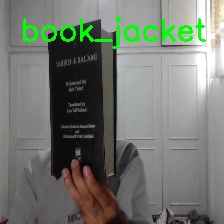

In [41]:
final_img_path = '/content/photo.jpg'
final_img = image.load_img(final_img_path)
final_img